Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


installing requirements


In [ ]:
!pip install basicsr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0

calculating flow between two images

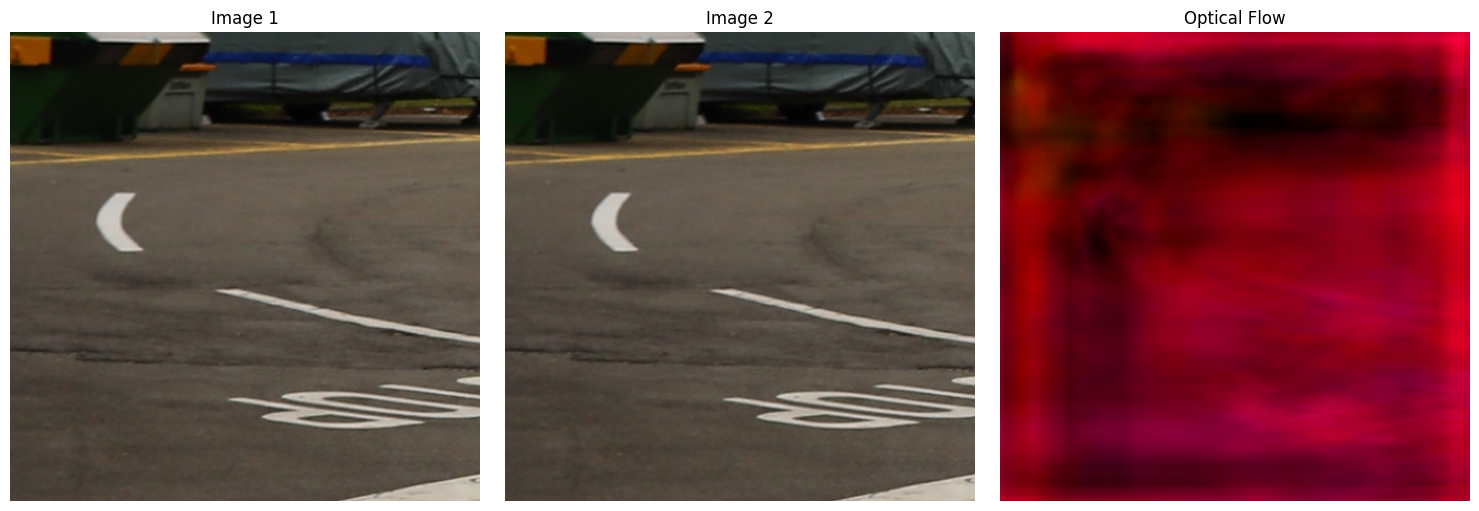

In [ ]:
import torch
from basicsr.archs.spynet_arch import SpyNet
import cv2
import numpy as np
import matplotlib.pyplot as plt

def flow_to_color(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

# Load SPyNet model
spynet = SpyNet()
spynet.eval()

# Load images
im1 = cv2.imread('/content/burst/1.jpg')
im2 = cv2.imread('/content/burst/1.jpg')

# Convert images to torch tensors and normalize
im1_tensor = torch.from_numpy(im1).permute(2, 0, 1).float() / 255.0
im2_tensor = torch.from_numpy(im2).permute(2, 0, 1).float() / 255.0

# Add batch dimension
im1_tensor = im1_tensor.unsqueeze(0)
im2_tensor = im2_tensor.unsqueeze(0)

# Compute optical flow using SPyNet
with torch.no_grad():
    flow = spynet(im2_tensor, im1_tensor)

# Convert flow to numpy array and reshape
flow_np = flow.squeeze().permute(1, 2, 0).cpu().numpy()

# Visualize the flow
flow_color = flow_to_color(flow_np)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(132)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

plt.subplot(133)
plt.imshow(flow_color)
plt.title('Optical Flow')
plt.axis('off')

plt.tight_layout()
plt.show()

computing flow, no warping, with patches (wrong approach)

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, patch_size=64, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()
        self.patch_size = patch_size

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def extract_patches(self, image):
        _, c, h, w = image.shape
        patches = image.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(-1, c, self.patch_size, self.patch_size)
        print(f"Extracted {patches.shape[0]} patches of size {patches.shape[1:]} from image of size {image.shape[1:]}")
        return patches

    def compute_flow(self, ref_patch, target_patch):
        flow = self.spynet(target_patch, ref_patch)
        print(f"Computed flow of shape {flow.shape} between patches")
        return flow

    def forward(self, burst):
        n, c, h, w = burst.shape
        print(f"Processing burst of shape {burst.shape}")
        ref_image = burst[0].unsqueeze(0)
        ref_patches = self.extract_patches(ref_image)

        flows = []
        for i in range(1, n):
            print(f"Processing image {i+1} of the burst")
            target_image = burst[i].unsqueeze(0)
            target_patches = self.extract_patches(target_image)

            image_flows = []
            for j, (ref_patch, target_patch) in enumerate(zip(ref_patches, target_patches)):
                print(f"Computing flow for patch {j+1}")
                flow = self.compute_flow(ref_patch.unsqueeze(0), target_patch.unsqueeze(0))
                image_flows.append(flow.squeeze(0))

            flows.append(torch.stack(image_flows))

        return torch.stack(flows)

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 14:
        raise ValueError(f"Expected 14 images in {burst_folder}, but found {len(image_files)}")

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst


def process_single_burst(model, burst_folder, device, output_folder):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vector = model(burst)

    print(f"Burst flow vector shape: {flow_vector.shape}")

    # Save the flow vector
    flow_output_path = os.path.join(output_folder, "flow_vector.pth")
    torch.save(flow_vector, flow_output_path)
    print(f"Flow vector saved to {flow_output_path}")

    # Visualize the flow vector

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynetWeights.pth"
    model = PatchAlignment(patch_size=64, spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst"
    output_folder = "/content/drive/MyDrive/Alignment/output"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device, output_folder)

if __name__ == "__main__":
    main()

Using device: cpu
Loaded adjusted SPyNet weights from /content/drive/MyDrive/Alignment/spynetWeights.pth
Processing burst in folder: /content/drive/MyDrive/Alignment/burst
Loaded burst of shape torch.Size([14, 3, 256, 256])
Processing burst of shape torch.Size([14, 3, 256, 256])
Extracted 16 patches of size torch.Size([3, 64, 64]) from image of size torch.Size([3, 256, 256])
Processing image 2 of the burst
Extracted 16 patches of size torch.Size([3, 64, 64]) from image of size torch.Size([3, 256, 256])
Computing flow for patch 1
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 2
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 3
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 4
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 5
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 6


computing flow of each image with regard to reference

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, patch_size=64, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()
        self.patch_size = patch_size

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def extract_patches(self, image):
        _, c, h, w = image.shape
        patches = image.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(-1, c, self.patch_size, self.patch_size)
        print(f"Extracted {patches.shape[0]} patches of size {patches.shape[1:]} from image of size {image.shape[1:]}")
        return patches

    def compute_flow(self, ref_patch, target_patch):
        flow = self.spynet(target_patch, ref_patch)
        print(f"Computed flow of shape {flow.shape} between patches")
        return flow

    def forward(self, burst):
        n, c, h, w = burst.shape
        print(f"Processing burst of shape {burst.shape}")
        ref_image = burst[0].unsqueeze(0)
        ref_patches = self.extract_patches(ref_image)

        flow_vectors = []
        for i in range(1, n):
            print(f"Processing image {i+1} of the burst")
            target_image = burst[i].unsqueeze(0)
            target_patches = self.extract_patches(target_image)

            image_flows = []
            for j, (ref_patch, target_patch) in enumerate(zip(ref_patches, target_patches)):
                print(f"Computing flow for patch {j+1}")
                flow = self.compute_flow(ref_patch.unsqueeze(0), target_patch.unsqueeze(0))
                image_flows.append(flow.squeeze(0))

            flow_vectors.append(torch.stack(image_flows))

        return flow_vectors

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 14:
        raise ValueError(f"Expected 14 images in {burst_folder}, but found {len(image_files)}")

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst

def process_single_burst(model, burst_folder, device):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vectors = model(burst)

    for i, flow_vector in enumerate(flow_vectors):
        print(f"Flow vector {i+1}: {flow_vector.shape}")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynetWeights.pth"
    model = PatchAlignment(patch_size=64, spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst"
    output_folder = "/content/drive/MyDrive/Alignment/output"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device)

if __name__ == "__main__":
    main()


Using device: cpu
Loaded adjusted SPyNet weights from /content/drive/MyDrive/Alignment/spynetWeights.pth
Processing burst in folder: /content/drive/MyDrive/Alignment/burst
Loaded burst of shape torch.Size([14, 3, 256, 256])
Processing burst of shape torch.Size([14, 3, 256, 256])
Extracted 16 patches of size torch.Size([3, 64, 64]) from image of size torch.Size([3, 256, 256])
Processing image 2 of the burst
Extracted 16 patches of size torch.Size([3, 64, 64]) from image of size torch.Size([3, 256, 256])
Computing flow for patch 1
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 2
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 3
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 4
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 5
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 6


testing code


In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY
from basicsr.archs.arch_util import flow_warp

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, patch_size=64, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()
        self.patch_size = patch_size

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def compute_flow(self, ref_image, target_image):
        return self.spynet(target_image, ref_image)

    def forward(self, burst):
        n, c, h, w = burst.shape
        ref_image = burst[0].unsqueeze(0)

        flow_vectors = []
        warped_images = []
        for i in range(1, n):
            target_image = burst[i].unsqueeze(0)

            # Compute flow
            flow = self.compute_flow(ref_image, target_image)
            flow_vectors.append(flow)

            # Warp image
            warped_image = flow_warp(target_image, flow.permute(0, 2, 3, 1))
            warped_images.append(warped_image)

        return flow_vectors, warped_images

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 14:
        raise ValueError(f"Expected 14 images in {burst_folder}, but found {len(image_files)}")

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst

def process_single_burst(model, burst_folder, device, output_folder):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vectors, warped_images = model(burst)

    # Save warped images and flow vectors
    for i, (flow, warped) in enumerate(zip(flow_vectors, warped_images)):
        # Save warped image
        warped_path = os.path.join(output_folder, f"warped_image_{i+1}.png")
        warped_img = warped.squeeze().cpu().numpy().transpose(1, 2, 0)
        warped_img = np.clip(warped_img * 255, 0, 255).astype('uint8')
        Image.fromarray(warped_img).save(warped_path)
        print(f"Saved warped image {i+1} to {warped_path}")

        # Save flow vector
        flow_path = os.path.join(output_folder, f"flow_vector_{i+1}.npy")
        np.save(flow_path, flow.squeeze().cpu().numpy())
        print(f"Saved flow vector {i+1} to {flow_path}")

    # Visualize results
    visualize_results(burst, warped_images, output_folder)

def visualize_results(burst, warped_images, output_folder):
    n_images = len(warped_images)
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))

    for i in range(n_images):
        # Reference image
        axes[i, 0].imshow(burst[0].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title(f"Reference Image")
        axes[i, 0].axis('off')

        # Original image
        axes[i, 1].imshow(burst[i+1].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"Original {i+2}")
        axes[i, 1].axis('off')

        # Warped image
        axes[i, 2].imshow(warped_images[i].squeeze().permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title(f"Warped {i+2}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "warped_images_visualization.png"))
    plt.close()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynetWeights.pth"
    model = PatchAlignment(patch_size=64, spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst"
    output_folder = "/content/drive/MyDrive/Alignment/output"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device, output_folder)

if __name__ == "__main__":
    main()

Using device: cpu
Loaded adjusted SPyNet weights from /content/drive/MyDrive/Alignment/spynetWeights.pth
Processing burst in folder: /content/drive/MyDrive/Alignment/burst
Loaded burst of shape torch.Size([14, 3, 256, 256])
Saved warped image 1 to /content/drive/MyDrive/Alignment/output/warped_image_1.png
Saved flow vector 1 to /content/drive/MyDrive/Alignment/output/flow_vector_1.npy
Saved warped image 2 to /content/drive/MyDrive/Alignment/output/warped_image_2.png
Saved flow vector 2 to /content/drive/MyDrive/Alignment/output/flow_vector_2.npy
Saved warped image 3 to /content/drive/MyDrive/Alignment/output/warped_image_3.png
Saved flow vector 3 to /content/drive/MyDrive/Alignment/output/flow_vector_3.npy
Saved warped image 4 to /content/drive/MyDrive/Alignment/output/warped_image_4.png
Saved flow vector 4 to /content/drive/MyDrive/Alignment/output/flow_vector_4.npy
Saved warped image 5 to /content/drive/MyDrive/Alignment/output/warped_image_5.png
Saved flow vector 5 to /content/drive

testing code

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY
from basicsr.archs.arch_util import flow_warp
import cv2

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def compute_flow(self, ref_image, target_image):
        return self.spynet(target_image, ref_image)

    def forward(self, burst):
        n, c, h, w = burst.shape
        ref_image = burst[0].unsqueeze(0)

        flow_vectors = []
        warped_images = []
        for i in range(1, n):
            target_image = burst[i].unsqueeze(0)

            # Compute flow
            flow = self.compute_flow(ref_image, target_image)
            flow_vectors.append(flow)
            print(f"Computed flow for image {i+1}. Flow shape: {flow.shape}, min: {flow.min().item()}, max: {flow.max().item()}")

            # Warp image
            warped_image = flow_warp(target_image, flow.permute(0, 2, 3, 1))
            warped_images.append(warped_image)
            print(f"Warped image {i+1}. Warped image shape: {warped_image.shape}")

        return flow_vectors, warped_images

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 14:
        raise ValueError(f"Expected 14 images in {burst_folder}, but found {len(image_files)}")

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst

def flow_to_color(flow):
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def process_single_burst(model, burst_folder, device, output_folder):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vectors, warped_images = model(burst)

    # Save and visualize results
    fig, axes = plt.subplots(len(flow_vectors), 5, figsize=(25, 5*len(flow_vectors)))

    # Reference image (first image in the burst)
    ref_img = burst[0].cpu().numpy().transpose(1, 2, 0)

    for i, (flow, warped) in enumerate(zip(flow_vectors, warped_images)):
        # Reference image
        axes[i, 0].imshow(ref_img)
        axes[i, 0].set_title("Reference Image")
        axes[i, 0].axis('off')

        # Original image
        orig_img = burst[i+1].cpu().numpy().transpose(1, 2, 0)
        axes[i, 1].imshow(orig_img)
        axes[i, 1].set_title(f"Original {i+2}")
        axes[i, 1].axis('off')

        # Flow visualization
        flow_img = flow_to_color(flow.squeeze().cpu().numpy().transpose(1, 2, 0))
        axes[i, 2].imshow(flow_img)
        axes[i, 2].set_title(f"Flow {i+2}")
        axes[i, 2].axis('off')

        # Warped image
        warped_img = warped.squeeze().cpu().numpy().transpose(1, 2, 0)
        axes[i, 3].imshow(warped_img)
        axes[i, 3].set_title(f"Warped {i+2}")
        axes[i, 3].axis('off')

        # Difference between original and warped
        diff_img = np.abs(orig_img - warped_img)
        axes[i, 4].imshow(diff_img)
        axes[i, 4].set_title(f"Difference {i+2}")
        axes[i, 4].axis('off')

        # Save individual images
        Image.fromarray((ref_img * 255).astype('uint8')).save(os.path.join(output_folder, "reference.png"))
        Image.fromarray((orig_img * 255).astype('uint8')).save(os.path.join(output_folder, f"original_{i+2}.png"))
        Image.fromarray(flow_img).save(os.path.join(output_folder, f"flow_{i+2}.png"))
        Image.fromarray((warped_img * 255).astype('uint8')).save(os.path.join(output_folder, f"warped_{i+2}.png"))
        Image.fromarray((diff_img * 255).astype('uint8')).save(os.path.join(output_folder, f"diff_{i+2}.png"))

        print(f"Processed image {i+2}:")
        print(f"  Flow min: {flow.min().item():.4f}, max: {flow.max().item():.4f}")
        print(f"  Warped image min: {warped_img.min():.4f}, max: {warped_img.max():.4f}")
        print(f"  Difference min: {diff_img.min():.4f}, max: {diff_img.max():.4f}")

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "burst_flow_analysis.png"))
    plt.close()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynetWeights.pth"
    model = PatchAlignment(spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst"
    output_folder = "/content/drive/MyDrive/Alignment/output"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device, output_folder)

if __name__ == "__main__":
    main()

Using device: cpu
Loaded adjusted SPyNet weights from /content/drive/MyDrive/Alignment/spynetWeights.pth
Processing burst in folder: /content/drive/MyDrive/Alignment/burst
Loaded burst of shape torch.Size([14, 3, 256, 256])
Computed flow for image 2. Flow shape: torch.Size([1, 2, 256, 256]), min: -1.310347080230713, max: 0.2132784128189087
Warped image 2. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 3. Flow shape: torch.Size([1, 2, 256, 256]), min: -1.482006311416626, max: 0.2941785454750061
Warped image 3. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 4. Flow shape: torch.Size([1, 2, 256, 256]), min: -1.9554686546325684, max: 0.6510695219039917
Warped image 4. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 5. Flow shape: torch.Size([1, 2, 256, 256]), min: -1.8059860467910767, max: 0.4281221032142639
Warped image 5. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 6. Flow shape: tor

NON PATCH BASED WORKING APPROACH

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY
from basicsr.archs.arch_util import flow_warp
import cv2
from skimage.metrics import structural_similarity as ssim

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def compute_flow(self, ref_image, target_image):
        return self.spynet(target_image, ref_image)

    def forward(self, burst):
        n, c, h, w = burst.shape
        ref_image = burst[0].unsqueeze(0)

        flow_vectors = []
        warped_images = []
        for i in range(1, n):
            target_image = burst[i].unsqueeze(0)

            # Compute flow
            flow = self.compute_flow(ref_image, target_image)
            flow_vectors.append(flow)
            print(f"Computed flow for image {i+1}. Flow shape: {flow.shape}, min: {flow.min().item()}, max: {flow.max().item()}")

            # Warp image
            warped_image = flow_warp(target_image, flow.permute(0, 2, 3, 1))
            warped_images.append(warped_image)
            print(f"Warped image {i+1}. Warped image shape: {warped_image.shape}")

        return flow_vectors, warped_images

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst

def flow_to_color(flow):
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)

def process_single_burst(model, burst_folder, device, output_folder):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vectors, warped_images = model(burst)

    # Save and visualize results
    num_flows = len(flow_vectors)
    fig, axes = plt.subplots(num_flows, 5, figsize=(25, 5*num_flows))

    # Ensure axes is always a 2D array for consistency
    if num_flows == 1:
        axes = np.expand_dims(axes, axis=0)

    # Reference image (first image in the burst)
    ref_img = burst[0].cpu().numpy().transpose(1, 2, 0)

    ssim_scores = []

    for i, (flow, warped) in enumerate(zip(flow_vectors, warped_images)):
        # Reference image
        axes[i, 0].imshow(ref_img)
        axes[i, 0].set_title("Reference Image")
        axes[i, 0].axis('off')

        # Original image
        orig_img = burst[i+1].cpu().numpy().transpose(1, 2, 0)
        axes[i, 1].imshow(orig_img)
        axes[i, 1].set_title(f"Original {i+2}")
        axes[i, 1].axis('off')

        # Flow visualization
        flow_img = flow_to_color(flow.squeeze().cpu().numpy().transpose(1, 2, 0))
        axes[i, 2].imshow(flow_img)
        axes[i, 2].set_title(f"Flow {i+2}")
        axes[i, 2].axis('off')

        # Warped image
        warped_img = warped.squeeze().cpu().numpy().transpose(1, 2, 0)
        axes[i, 3].imshow(warped_img)
        axes[i, 3].set_title(f"Warped {i+2}")
        axes[i, 3].axis('off')

        # Difference between original and warped
        diff_img = np.abs(orig_img - warped_img)
        axes[i, 4].imshow(diff_img)
        axes[i, 4].set_title(f"Difference {i+2}")
        axes[i, 4].axis('off')

        # Calculate SSIM
        ssim_score = calculate_ssim(ref_img, warped_img)
        ssim_scores.append(ssim_score)

        # Save individual images
        Image.fromarray((ref_img * 255).astype('uint8')).save(os.path.join(output_folder, "reference.png"))
        Image.fromarray((orig_img * 255).astype('uint8')).save(os.path.join(output_folder, f"original_{i+2}.png"))
        Image.fromarray(flow_img).save(os.path.join(output_folder, f"flow_{i+2}.png"))
        Image.fromarray((warped_img * 255).astype('uint8')).save(os.path.join(output_folder, f"warped_{i+2}.png"))
        Image.fromarray((diff_img * 255).astype('uint8')).save(os.path.join(output_folder, f"diff_{i+2}.png"))

        print(f"Processed image {i+2}:")
        print(f"  Flow min: {flow.min().item():.4f}, max: {flow.max().item():.4f}")
        print(f"  Warped image min: {warped_img.min().item():.4f}, max: {warped_img.max().item():.4f}")
        print(f"  Difference min: {diff_img.min().item():.4f}, max: {diff_img.max().item():.4f}")
        print(f"  SSIM score: {ssim_score:.4f}")

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "burst_flow_analysis.png"))
    plt.close()

    # Calculate and print average SSIM
    avg_ssim = np.mean(ssim_scores)
    print(f"Average SSIM score: {avg_ssim:.4f}")

    # Save SSIM scores to a text file
    with open(os.path.join(output_folder, "ssim_scores.txt"), "w") as f:
        for i, score in enumerate(ssim_scores):
            f.write(f"Image {i+2} SSIM: {score:.4f}\n")
        f.write(f"Average SSIM: {avg_ssim:.4f}\n")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynetWeights.pth"
    model = PatchAlignment(spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst3/generated_burst"
    output_folder = "/content/drive/MyDrive/Alignment/outputSyntheticBurstNoPatchesSSIM"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device, output_folder)

if __name__ == "__main__":
    main()

Using device: cpu
Loaded adjusted SPyNet weights from /content/drive/MyDrive/Alignment/spynetWeights.pth
Processing burst in folder: /content/drive/MyDrive/Alignment/burst3/generated_burst
Loaded burst of shape torch.Size([14, 3, 256, 256])
Computed flow for image 2. Flow shape: torch.Size([1, 2, 256, 256]), min: -0.07988099753856659, max: 1.2318897247314453
Warped image 2. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 3. Flow shape: torch.Size([1, 2, 256, 256]), min: -0.041382141411304474, max: 1.2797987461090088
Warped image 3. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 4. Flow shape: torch.Size([1, 2, 256, 256]), min: -0.009069621562957764, max: 1.2811137437820435
Warped image 4. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow for image 5. Flow shape: torch.Size([1, 2, 256, 256]), min: -0.016342414543032646, max: 1.2607905864715576
Warped image 5. Warped image shape: torch.Size([1, 3, 256, 256])
Computed flow fo

<ipython-input-8-fd147f77e1d4>:105: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)


Processed image 2:
  Flow min: -0.0799, max: 1.2319
  Warped image min: 0.0000, max: 0.8786
  Difference min: 0.0000, max: 0.6330
  SSIM score: 0.4385
Processed image 3:
  Flow min: -0.0414, max: 1.2798
  Warped image min: 0.0000, max: 0.8110
  Difference min: 0.0000, max: 0.6474
  SSIM score: 0.4835
Processed image 4:
  Flow min: -0.0091, max: 1.2811
  Warped image min: 0.0000, max: 0.8277
  Difference min: 0.0000, max: 0.7680
  SSIM score: 0.5467
Processed image 5:
  Flow min: -0.0163, max: 1.2608
  Warped image min: 0.0000, max: 0.8311
  Difference min: 0.0000, max: 0.4375
  SSIM score: 0.5069
Processed image 6:
  Flow min: 0.0185, max: 1.2589
  Warped image min: 0.0000, max: 0.8507
  Difference min: 0.0000, max: 0.6261
  SSIM score: 0.4895
Processed image 7:
  Flow min: -0.0194, max: 1.2686
  Warped image min: 0.0003, max: 0.8568
  Difference min: 0.0000, max: 0.6074
  SSIM score: 0.5626
Processed image 8:
  Flow min: -0.0273, max: 1.2201
  Warped image min: 0.0000, max: 0.8794
  D

generating synthetic burst


In [ ]:
import torch
import random
import cv2
import numpy as np
import torch.nn.functional as F
import data_processing.camera_pipeline as rgb2raw
from utils.data_format_utils import torch_to_numpy, numpy_to_torch


def random_crop(frames, crop_sz):
    """ Extract a random crop of size crop_sz from the input frames. If the crop_sz is larger than the input image size,
    then the largest possible crop of same aspect ratio as crop_sz will be extracted from frames, and upsampled to
    crop_sz.
    """
    if not isinstance(crop_sz, (tuple, list)):
        crop_sz = (crop_sz, crop_sz)
    crop_sz = torch.tensor(crop_sz).float()

    shape = frames.shape

    # Select scale_factor. Ensure the crop fits inside the image
    max_scale_factor = torch.tensor(shape[-2:]).float() / crop_sz
    max_scale_factor = max_scale_factor.min().item()

    if max_scale_factor < 1.0:
        scale_factor = max_scale_factor
    else:
        scale_factor = 1.0

    # Extract the crop
    orig_crop_sz = (crop_sz * scale_factor).floor()

    assert orig_crop_sz[-2] <= shape[-2] and orig_crop_sz[-1] <= shape[-1], 'Bug in crop size estimation!'

    r1 = random.randint(0, shape[-2] - orig_crop_sz[-2])
    c1 = random.randint(0, shape[-1] - orig_crop_sz[-1])

    r2 = r1 + orig_crop_sz[0].int().item()
    c2 = c1 + orig_crop_sz[1].int().item()

    frames_crop = frames[:, r1:r2, c1:c2]

    # Resize to crop_sz
    if scale_factor < 1.0:
        frames_crop = F.interpolate(frames_crop.unsqueeze(0), size=crop_sz.int().tolist(), mode='bilinear', align_corners=True).squeeze(0)
    return frames_crop


def rgb2rawburst(image, burst_size, downsample_factor=1, burst_transformation_params=None,
                 image_processing_params=None, interpolation_type='bilinear'):
    """ Generates a synthetic LR RAW burst from the input image. The input sRGB image is first converted to linear
    sensor space using an inverse camera pipeline. A LR burst is then generated by applying random
    transformations defined by burst_transformation_params to the input image, and downsampling it by the
    downsample_factor. The generated burst is then mosaicekd and corrputed by random noise.
    """

    if image_processing_params is None:
        image_processing_params = {}

    _defaults = {'random_ccm': True, 'random_gains': True, 'smoothstep': True, 'gamma': True, 'add_noise': True}
    for k, v in _defaults.items():
        if k not in image_processing_params:
            image_processing_params[k] = v

    # Sample camera pipeline params
    if image_processing_params['random_ccm']:
        rgb2cam = rgb2raw.random_ccm()
    else:
        rgb2cam = torch.eye(3).float()
    cam2rgb = rgb2cam.inverse()

    # Sample gains
    if image_processing_params['random_gains']:
        rgb_gain, red_gain, blue_gain = rgb2raw.random_gains()
    else:
        rgb_gain, red_gain, blue_gain = (1.0, 1.0, 1.0)

    # Approximately inverts global tone mapping.
    use_smoothstep = image_processing_params['smoothstep']
    if use_smoothstep:
        image = rgb2raw.invert_smoothstep(image)

    # Inverts gamma compression.
    use_gamma = image_processing_params['gamma']
    if use_gamma:
        image = rgb2raw.gamma_expansion(image)

    # Inverts color correction.
    image = rgb2raw.apply_ccm(image, rgb2cam)

    # Approximately inverts white balance and brightening.
    image = rgb2raw.safe_invert_gains(image, rgb_gain, red_gain, blue_gain)

    # Clip saturated pixels.
    image = image.clamp(0.0, 1.0)

    # Generate LR burst
    image_burst_rgb, flow_vectors = single2lrburst(image, burst_size=burst_size,
                                                   downsample_factor=downsample_factor,
                                                   transformation_params=burst_transformation_params,
                                                   interpolation_type=interpolation_type)

    # mosaic
    image_burst = rgb2raw.mosaic(image_burst_rgb.clone())

    # Add noise
    if image_processing_params['add_noise']:
        shot_noise_level, read_noise_level = rgb2raw.random_noise_levels()
        image_burst = rgb2raw.add_noise(image_burst, shot_noise_level, read_noise_level)
    else:
        shot_noise_level = 0
        read_noise_level = 0

    # Clip saturated pixels.
    image_burst = image_burst.clamp(0.0, 1.0)

    meta_info = {'rgb2cam': rgb2cam, 'cam2rgb': cam2rgb, 'rgb_gain': rgb_gain, 'red_gain': red_gain,
                 'blue_gain': blue_gain, 'smoothstep': use_smoothstep, 'gamma': use_gamma,
                 'shot_noise_level': shot_noise_level, 'read_noise_level': read_noise_level}
    return image_burst, image, image_burst_rgb, flow_vectors, meta_info


def get_tmat(image_shape, translation, theta, shear_values, scale_factors):
    """ Generates a transformation matrix corresponding to the input transformation parameters """
    im_h, im_w = image_shape

    t_mat = np.identity(3)

    t_mat[0, 2] = translation[0]
    t_mat[1, 2] = translation[1]
    t_rot = cv2.getRotationMatrix2D((im_w * 0.5, im_h * 0.5), theta, 1.0)
    t_rot = np.concatenate((t_rot, np.array([0.0, 0.0, 1.0]).reshape(1, 3)))

    t_shear = np.array([[1.0, shear_values[0], -shear_values[0] * 0.5 * im_w],
                        [shear_values[1], 1.0, -shear_values[1] * 0.5 * im_h],
                        [0.0, 0.0, 1.0]])

    t_scale = np.array([[scale_factors[0], 0.0, 0.0],
                        [0.0, scale_factors[1], 0.0],
                        [0.0, 0.0, 1.0]])

    t_mat = t_scale @ t_rot @ t_shear @ t_mat

    t_mat = t_mat[:2, :]

    return t_mat


def single2lrburst(image, burst_size, downsample_factor=1, transformation_params=None,
                   interpolation_type='bilinear'):
    """ Generates a burst of size burst_size from the input image by applying random transformations defined by
    transformation_params, and downsampling the resulting burst by downsample_factor.
    """

    if interpolation_type == 'bilinear':
        interpolation = cv2.INTER_LINEAR
    elif interpolation_type == 'lanczos':
        interpolation = cv2.INTER_LANCZOS4
    else:
        raise ValueError

    normalize = False
    if isinstance(image, torch.Tensor):
        if image.max() < 2.0:
            image = image * 255.0
            normalize = True
        image = torch_to_numpy(image).astype(np.uint8)

    burst = []
    sample_pos_inv_all = []

    rvs, cvs = torch.meshgrid([torch.arange(0, image.shape[0]),
                               torch.arange(0, image.shape[1])])

    sample_grid = torch.stack((cvs, rvs, torch.ones_like(cvs)), dim=-1).float()

    for i in range(burst_size):
        if i == 0:
            # For base image, do not apply any random transformations. We only translate the image to center the
            # sampling grid
            shift = (downsample_factor / 2.0) - 0.5
            translation = (shift, shift)
            theta = 0.0
            shear_factor = (0.0, 0.0)
            scale_factor = (1.0, 1.0)
        else:
            # Sample random image transformation parameters
            max_translation = transformation_params.get('max_translation', 0.0)

            if max_translation <= 0.01:
                shift = (downsample_factor / 2.0) - 0.5
                translation = (shift, shift)
            else:
                translation = (random.uniform(-max_translation, max_translation),
                               random.uniform(-max_translation, max_translation))

            max_rotation = transformation_params.get('max_rotation', 0.0)
            theta = random.uniform(-max_rotation, max_rotation)

            max_shear = transformation_params.get('max_shear', 0.0)
            shear_x = random.uniform(-max_shear, max_shear)
            shear_y = random.uniform(-max_shear, max_shear)
            shear_factor = (shear_x, shear_y)

            max_ar_factor = transformation_params.get('max_ar_factor', 0.0)
            ar_factor = np.exp(random.uniform(-max_ar_factor, max_ar_factor))

            max_scale = transformation_params.get('max_scale', 0.0)
            scale_factor = np.exp(random.uniform(-max_scale, max_scale))

            scale_factor = (scale_factor, scale_factor * ar_factor)

        output_sz = (image.shape[1], image.shape[0])

        # Generate a affine transformation matrix corresponding to the sampled parameters
        t_mat = get_tmat((image.shape[0], image.shape[1]), translation, theta, shear_factor, scale_factor)
        t_mat_tensor = torch.from_numpy(t_mat)

        # Apply the sampled affine transformation
        image_t = cv2.warpAffine(image, t_mat, output_sz, flags=interpolation,
                                 borderMode=cv2.BORDER_CONSTANT)

        t_mat_tensor_3x3 = torch.cat((t_mat_tensor.float(), torch.tensor([0.0, 0.0, 1.0]).view(1, 3)), dim=0)
        t_mat_tensor_inverse = t_mat_tensor_3x3.inverse()[:2, :].contiguous()

        sample_pos_inv = torch.mm(sample_grid.view(-1, 3), t_mat_tensor_inverse.t().float()).view(
            *sample_grid.shape[:2], -1)

        if transformation_params.get('border_crop') is not None:
            border_crop = transformation_params.get('border_crop')

            image_t = image_t[border_crop:-border_crop, border_crop:-border_crop, :]
            sample_pos_inv = sample_pos_inv[border_crop:-border_crop, border_crop:-border_crop, :]

        # Downsample the image
        image_t = cv2.resize(image_t, None, fx=1.0 / downsample_factor, fy=1.0 / downsample_factor,
                             interpolation=interpolation)
        sample_pos_inv = cv2.resize(sample_pos_inv.numpy(), None, fx=1.0 / downsample_factor,
                                    fy=1.0 / downsample_factor,
                                    interpolation=interpolation)

        sample_pos_inv = torch.from_numpy(sample_pos_inv).permute(2, 0, 1)

        if normalize:
            image_t = numpy_to_torch(image_t).float() / 255.0
        else:
            image_t = numpy_to_torch(image_t).float()
        burst.append(image_t)
        sample_pos_inv_all.append(sample_pos_inv / downsample_factor)

    burst_images = torch.stack(burst)
    sample_pos_inv_all = torch.stack(sample_pos_inv_all)

    # Compute the flow vectors to go from the i'th burst image to the base image
    flow_vectors = sample_pos_inv_all - sample_pos_inv_all[:, :1, ...]

    return burst_images, flow_vectors

generating synthetic burst

In [ ]:
import torch
import os
import cv2
import numpy as np
import torchvision.transforms as tfm
from PIL import Image

class SingleImageBurst(torch.utils.data.Dataset):
    def __init__(self, image_path, burst_size=8, crop_sz=384):
        self.image_path = image_path
        self.burst_size = burst_size
        self.crop_sz = crop_sz
        self.transform = tfm.Compose([
            tfm.ToTensor(),
            tfm.RandomCrop(crop_sz)
        ])

        # Load the image
        self.image = self.load_image(image_path)
        if self.image is None:
            raise ValueError(f"Failed to load image from {image_path}")

    def load_image(self, path):
        img = cv2.imread(path)
        if img is None:
            print(f"Failed to load image: {path}")
            return None
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def __len__(self):
        return 1  # We only have one image

    def generate_burst(self, image):
        burst = []
        for _ in range(self.burst_size):
            # Apply random transformations to simulate a burst
            transformed = self.apply_random_transform(image)
            burst.append(transformed)
        return torch.stack(burst)

    def apply_random_transform(self, image):
        # Apply random shift and rotation
        rows, cols = image.shape[:2]
        M = np.float32([[1, 0, np.random.randint(-20, 20)],
                        [0, 1, np.random.randint(-20, 20)]])
        shifted = cv2.warpAffine(image, M, (cols, rows))

        angle = np.random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated = cv2.warpAffine(shifted, M, (cols, rows))

        return self.transform(rotated)

    def __getitem__(self, index):
        # Generate burst from the single image
        burst = self.generate_burst(self.image)

        # Use the original image as ground truth
        frame_gt = self.transform(self.image)

        # Generate dummy flow vectors
        flow_vectors = torch.zeros(self.burst_size, 2, self.crop_sz, self.crop_sz)

        # Dummy meta info
        meta_info = {"original_image_path": self.image_path}

        return burst, frame_gt, flow_vectors, meta_info

    def save_burst(self, burst, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        for i, frame in enumerate(burst):
            frame_np = (frame.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(save_dir, f"frame_{i:02d}.png"), cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR))

# Usage
image_path = "/content/drive/MyDrive/Alignment/burst3/Copy of 6.jpg"
burst_size = 14
crop_sz = 384

try:
    dataset = SingleImageBurst(image_path, burst_size=burst_size, crop_sz=crop_sz)
    burst, frame_gt, flow_vectors, meta_info = dataset[0]

    print(f"Burst shape: {burst.shape}")
    print(f"Ground truth frame shape: {frame_gt.shape}")
    print(f"Flow vectors shape: {flow_vectors.shape}")

    # Save the generated burst
    save_dir = os.path.join(os.path.dirname(image_path), "generated_burst")
    dataset.save_burst(burst, save_dir)
    print(f"Burst saved in: {save_dir}")

except ValueError as e:
    print(f"Error occurred: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

Burst shape: torch.Size([14, 3, 384, 384])
Ground truth frame shape: torch.Size([3, 384, 384])
Flow vectors shape: torch.Size([14, 2, 384, 384])
Burst saved in: /content/drive/MyDrive/Alignment/burst3/generated_burst


WORKING PATCH BASED


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY
from basicsr.archs.arch_util import flow_warp
import cv2
from skimage.metrics import structural_similarity as ssim

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, patch_size=64, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()
        self.patch_size = patch_size

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def extract_patches(self, image):
        _, c, h, w = image.shape
        patches = image.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(-1, c, self.patch_size, self.patch_size)
        print(f"Extracted {patches.shape[0]} patches of size {patches.shape[1:]} from image of size {image.shape[1:]}")
        return patches

    def compute_flow(self, ref_patch, target_patch):
        flow = self.spynet(target_patch, ref_patch)
        print(f"Computed flow of shape {flow.shape} between patches")
        return flow

    def combine_patch_flows(self, patch_flows, h, w):
        num_patches = len(patch_flows)
        patches_per_row = w // self.patch_size

        full_flow = torch.zeros(1, 2, h, w, device=patch_flows[0].device)

        for i, patch_flow in enumerate(patch_flows):
            row = i // patches_per_row
            col = i % patches_per_row
            y_start = row * self.patch_size
            x_start = col * self.patch_size
            full_flow[0, :, y_start:y_start+self.patch_size, x_start:x_start+self.patch_size] = patch_flow

        return full_flow

    def forward(self, burst):
        n, c, h, w = burst.shape
        print(f"Processing burst of shape {burst.shape}")
        ref_image = burst[0].unsqueeze(0)
        ref_patches = self.extract_patches(ref_image)

        flow_vectors = []
        warped_images = []
        for i in range(1, n):
            print(f"Processing image {i+1} of the burst")
            target_image = burst[i].unsqueeze(0)
            target_patches = self.extract_patches(target_image)

            image_flows = []
            for j, (ref_patch, target_patch) in enumerate(zip(ref_patches, target_patches)):
                print(f"Computing flow for patch {j+1}")
                flow = self.compute_flow(ref_patch.unsqueeze(0), target_patch.unsqueeze(0))
                image_flows.append(flow.squeeze(0))

            # Combine flows from all patches
            full_flow = self.combine_patch_flows(image_flows, h, w)
            flow_vectors.append(full_flow)

            # Warp the entire image using BasicSR's flow_warp
            warped_image = flow_warp(target_image, full_flow.permute(0, 2, 3, 1))
            warped_images.append(warped_image)
            print(f"Flow Vector for Warping {full_flow.shape}")

        return flow_vectors, warped_images

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst

def flow_to_color(flow):
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)

def process_single_burst(model, burst_folder, device, output_folder):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vectors, warped_images = model(burst)

    n_images = len(flow_vectors)
    fig, axes = plt.subplots(n_images, 5, figsize=(25, 5*n_images))

    ssim_scores = []

    for i in range(n_images):
        # Reference image
        ref_img = burst[0].cpu().numpy().transpose(1, 2, 0)
        axes[i, 0].imshow(ref_img)
        axes[i, 0].set_title("Reference Image")
        axes[i, 0].axis('off')

        # Original image
        orig_img = burst[i+1].cpu().numpy().transpose(1, 2, 0)
        axes[i, 1].imshow(orig_img)
        axes[i, 1].set_title(f"Original {i+2}")
        axes[i, 1].axis('off')

        # Flow visualization
        flow = flow_vectors[i].squeeze().cpu().numpy().transpose(1, 2, 0)
        flow_img = flow_to_color(flow)
        axes[i, 2].imshow(flow_img)
        axes[i, 2].set_title(f"Flow {i+2}")
        axes[i, 2].axis('off')

        # Warped image
        warped_img = warped_images[i].squeeze().cpu().numpy().transpose(1, 2, 0)
        axes[i, 3].imshow(warped_img)
        axes[i, 3].set_title(f"Warped {i+2}")
        axes[i, 3].axis('off')

        # Difference image
        diff_img = np.abs(orig_img - warped_img)
        axes[i, 4].imshow(diff_img)
        axes[i, 4].set_title(f"Difference {i+2}")
        axes[i, 4].axis('off')

        # Calculate SSIM
        ssim_score = calculate_ssim(ref_img, warped_img)
        ssim_scores.append(ssim_score)
        print(f"SSIM score for image {i+2}: {ssim_score:.4f}")

        # Save individual images
        Image.fromarray((ref_img * 255).astype('uint8')).save(os.path.join(output_folder, "reference.png"))
        Image.fromarray((orig_img * 255).astype('uint8')).save(os.path.join(output_folder, f"original_{i+2}.png"))
        Image.fromarray(flow_img).save(os.path.join(output_folder, f"flow_{i+2}.png"))
        Image.fromarray((warped_img * 255).astype('uint8')).save(os.path.join(output_folder, f"warped_{i+2}.png"))
        Image.fromarray((diff_img * 255).astype('uint8')).save(os.path.join(output_folder, f"diff_{i+2}.png"))

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "burst_flow_analysis.png"))
    plt.close()

    # Calculate and print average SSIM
    avg_ssim = np.mean(ssim_scores)
    print(f"Average SSIM score: {avg_ssim:.4f}")

    # Save SSIM scores to a text file
    with open(os.path.join(output_folder, "ssim_scores.txt"), "w") as f:
        for i, score in enumerate(ssim_scores):
            f.write(f"Image {i+2} SSIM: {score:.4f}\n")
        f.write(f"Average SSIM: {avg_ssim:.4f}\n")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynetWeights.pth"
    model = PatchAlignment(patch_size=64, spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst3/generated_burst"
    output_folder = "/content/drive/MyDrive/Alignment/outputSyntheticBurstSSIM"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device, output_folder)

if __name__ == "__main__":
    main()

Using device: cpu
Loaded adjusted SPyNet weights from /content/drive/MyDrive/Alignment/spynetWeights.pth
Processing burst in folder: /content/drive/MyDrive/Alignment/burst3/generated_burst
Loaded burst of shape torch.Size([14, 3, 256, 256])
Processing burst of shape torch.Size([14, 3, 256, 256])
Extracted 16 patches of size torch.Size([3, 64, 64]) from image of size torch.Size([3, 256, 256])
Processing image 2 of the burst
Extracted 16 patches of size torch.Size([3, 64, 64]) from image of size torch.Size([3, 256, 256])
Computing flow for patch 1
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 2
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 3
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 4
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing flow for patch 5
Computed flow of shape torch.Size([1, 2, 64, 64]) between patches
Computing 

<ipython-input-23-79123828010c>:139: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)


SSIM score for image 2: 0.4470
SSIM score for image 3: 0.4858
SSIM score for image 4: 0.5438
SSIM score for image 5: 0.5255
SSIM score for image 6: 0.4810
SSIM score for image 7: 0.5525
SSIM score for image 8: 0.4454
SSIM score for image 9: 0.5623
SSIM score for image 10: 0.5287
SSIM score for image 11: 0.5142
SSIM score for image 12: 0.4214
SSIM score for image 13: 0.4727
SSIM score for image 14: 0.5489
Average SSIM score: 0.5023


In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from basicsr.archs.spynet_arch import SpyNet
from basicsr.utils.registry import ARCH_REGISTRY
from basicsr.archs.arch_util import flow_warp
import cv2
from skimage.metrics import structural_similarity as ssim

def adjust_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'basic_module' in k:
            parts = k.split('.')
            new_key = f"basic_module.{parts[1]}.basic_module.{parts[3]}"

            if 'weight' in k or 'bias' in k:
                if v.size() != state_dict[k].size():
                    if len(v.size()) == 4:  # For convolutional layers
                        v = F.interpolate(v.unsqueeze(0), size=state_dict[k].shape[2:], mode='bilinear', align_corners=False).squeeze(0)
                        if v.size(0) != state_dict[k].size(0) or v.size(1) != state_dict[k].size(1):
                            v = v[:state_dict[k].size(0), :state_dict[k].size(1)]
                    elif len(v.size()) == 1:  # For bias
                        if v.size(0) < state_dict[k].size(0):
                            v = torch.cat([v, torch.zeros(state_dict[k].size(0) - v.size(0))])
                        else:
                            v = v[:state_dict[k].size(0)]

            new_state_dict[new_key] = v
    return new_state_dict

class PatchAlignment(nn.Module):
    def __init__(self, patch_size=64, spynet_pretrain_path=None):
        super(PatchAlignment, self).__init__()
        self.spynet = SpyNet()
        self.patch_size = patch_size

        if spynet_pretrain_path is not None:
            self.load_spynet_weights(spynet_pretrain_path)

    def load_spynet_weights(self, pretrain_path):
        state_dict = torch.load(pretrain_path, map_location='cpu')
        adjusted_state_dict = adjust_state_dict(state_dict)
        self.spynet.load_state_dict(adjusted_state_dict, strict=False)
        print(f"Loaded adjusted SPyNet weights from {pretrain_path}")

    def extract_patches(self, image):
        _, c, h, w = image.shape
        patches = image.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(-1, c, self.patch_size, self.patch_size)
        print(f"Extracted {patches.shape[0]} patches of size {patches.shape[1:]} from image of size {image.shape[1:]}")
        return patches

    def compute_flow(self, ref_patch, target_patch):
        flow = self.spynet(target_patch, ref_patch)
        flow_avg = torch.mean(flow, dim=(2, 3), keepdim=True)
        print(f"Computed flow of shape {flow_avg.shape} between patches")
        return flow_avg

    def combine_patch_flows(self, patch_flows, h, w):
        num_patches = len(patch_flows)
        patches_per_row = w // self.patch_size

        full_flow = torch.zeros(1, 2, h, w, device=patch_flows[0].device)

        for i, patch_flow in enumerate(patch_flows):
            row = i // patches_per_row
            col = i % patches_per_row
            y_start = row * self.patch_size
            x_start = col * self.patch_size
            # Expand 1,2,1,1 to 1,2,64,64 by repeating the values 64 times
            expanded_flow = patch_flow.repeat(1, 1, self.patch_size, self.patch_size)
            full_flow[0, :, y_start:y_start+self.patch_size, x_start:x_start+self.patch_size] = expanded_flow[0]

        return full_flow

    def forward(self, burst):
        n, c, h, w = burst.shape
        print(f"Processing burst of shape {burst.shape}")
        ref_image = burst[0].unsqueeze(0)
        ref_patches = self.extract_patches(ref_image)

        flow_vectors = []
        warped_images = []
        for i in range(1, n):
            print(f"Processing image {i+1} of the burst")
            target_image = burst[i].unsqueeze(0)
            target_patches = self.extract_patches(target_image)

            image_flows = []
            for j, (ref_patch, target_patch) in enumerate(zip(ref_patches, target_patches)):
                print(f"Computing flow for patch {j+1}")
                flow = self.compute_flow(ref_patch.unsqueeze(0), target_patch.unsqueeze(0))
                image_flows.append(flow.squeeze(0))

            # Combine flows from all patches
            full_flow = self.combine_patch_flows(image_flows, h, w)
            flow_vectors.append(full_flow)

            # Warp the entire image using BasicSR's flow_warp
            warped_image = flow_warp(target_image, full_flow.permute(0, 2, 3, 1))
            warped_images.append(warped_image)
            print(f"Flow Vector for Warping {full_flow.shape}")

        return flow_vectors, warped_images

def load_burst(burst_folder, image_size=(256, 256)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    burst_images = []
    image_files = sorted([f for f in os.listdir(burst_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for image_file in image_files:
        image_path = os.path.join(burst_folder, image_file)
        with Image.open(image_path) as img:
            img_tensor = preprocess(img)
            burst_images.append(img_tensor)

    burst = torch.stack(burst_images)
    print(f"Loaded burst of shape {burst.shape}")
    return burst

def flow_to_color(flow):
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), channel_axis=2)

def process_single_burst(model, burst_folder, device, output_folder):
    print(f"Processing burst in folder: {burst_folder}")
    burst = load_burst(burst_folder)
    burst = burst.to(device)

    with torch.no_grad():
        flow_vectors, warped_images = model(burst)

    n_images = len(flow_vectors)
    fig, axes = plt.subplots(n_images, 5, figsize=(25, 5*n_images))

    ssim_scores = []

    for i in range(n_images):
        # Reference image
        ref_img = burst[0].cpu().numpy().transpose(1, 2, 0)
        axes[i, 0].imshow(ref_img)
        axes[i, 0].set_title("Reference Image")
        axes[i, 0].axis('off')

        # Original image
        orig_img = burst[i+1].cpu().numpy().transpose(1, 2, 0)
        axes[i, 1].imshow(orig_img)
        axes[i, 1].set_title(f"Original {i+2}")
        axes[i, 1].axis('off')

        # Flow visualization
        flow = flow_vectors[i].squeeze().cpu().numpy().transpose(1, 2, 0)
        flow_img = flow_to_color(flow)
        axes[i, 2].imshow(flow_img)
        axes[i, 2].set_title(f"Flow {i+2}")
        axes[i, 2].axis('off')

        # Warped image
        warped_img = warped_images[i].squeeze().cpu().numpy().transpose(1, 2, 0)
        axes[i, 3].imshow(warped_img)
        axes[i, 3].set_title(f"Warped {i+2}")
        axes[i, 3].axis('off')

        # Difference image
        diff_img = np.abs(orig_img - warped_img)
        axes[i, 4].imshow(diff_img)
        axes[i, 4].set_title(f"Difference {i+2}")
        axes[i, 4].axis('off')

        # Calculate SSIM
        ssim_score = calculate_ssim(ref_img, warped_img)
        ssim_scores.append(ssim_score)
        print(f"SSIM score for image {i+2}: {ssim_score:.4f}")

        # Save individual images
        Image.fromarray((ref_img * 255).astype('uint8')).save(os.path.join(output_folder, "reference.png"))
        Image.fromarray((orig_img * 255).astype('uint8')).save(os.path.join(output_folder, f"original_{i+2}.png"))
        Image.fromarray(flow_img).save(os.path.join(output_folder, f"flow_{i+2}.png"))
        Image.fromarray((warped_img * 255).astype('uint8')).save(os.path.join(output_folder, f"warped_{i+2}.png"))
        Image.fromarray((diff_img * 255).astype('uint8')).save(os.path.join(output_folder, f"diff_{i+2}.png"))

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "burst_flow_analysis.png"))
    plt.close()

    # Calculate and print average SSIM
    avg_ssim = np.mean(ssim_scores)
    print(f"Average SSIM score: {avg_ssim:.4f}")

    # Save SSIM scores to a text file
    with open(os.path.join(output_folder, "ssim_scores.txt"), "w") as f:
        for i, score in enumerate(ssim_scores):
            f.write(f"Image {i+2} SSIM: {score:.4f}\n")
        f.write(f"Average SSIM: {avg_ssim:.4f}\n")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    spynet_pretrain_path = "/content/drive/MyDrive/Alignment/spynet_sintel_final-3d2a1287.pth"
    model = PatchAlignment(patch_size=64, spynet_pretrain_path=spynet_pretrain_path).to(device)
    model.eval()

    burst_folder = "/content/drive/MyDrive/Alignment/burst3/generated_burst"
    output_folder = "/content/drive/MyDrive/Alignment/outputSyntheticBurstSSIM2"
    os.makedirs(output_folder, exist_ok=True)

    process_single_burst(model, burst_folder, device, output_folder)

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'basicsr'